<a href="https://colab.research.google.com/github/DvidalBe/deep-neuro-classifier/blob/main/res_sphere.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [14]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, random_split
from tqdm import tqdm
import matplotlib.pyplot as plt
import os
import tarfile
import urllib.request


In [15]:
class BaseClassifier:
    def __init__(self, num_classes, model_name='resnet50', batch_size=32, lr=0.001, device=None):
        """
        Flexible image classifier that works with any dataset.

        Args:
            num_classes (int): Number of classes in your dataset
            model_name (str): Model architecture ('resnet50', 'resnet18', 'mobilenet_v2')
            batch_size (int): Batch size for training
            lr (float): Learning rate
            device: PyTorch device (auto-detected if None)
        """
        self.num_classes = num_classes
        self.batch_size = batch_size
        self.lr = lr
        self.device = device or torch.device("cuda" if torch.cuda.is_available() else "cpu")

        # Initialize model
        self.model = self._create_model(model_name)
        self.model.to(self.device)

        # Loss and optimizer
        self.criterion = nn.CrossEntropyLoss()
        self.optimizer = optim.Adam(self.model.parameters(), lr=self.lr)

        # Training history
        self.train_losses = []
        self.train_accuracies = []

        print(f"Using device: {self.device}")
        print(f"Model: {model_name} with {num_classes} classes")

    def _create_model(self, model_name):
        """Create and modify pretrained model for the number of classes."""
        if model_name == 'resnet50':
            model = models.resnet50(pretrained=True)
            model.fc = nn.Linear(model.fc.in_features, self.num_classes)
        elif model_name == 'resnet18':
            model = models.resnet18(pretrained=True)
            model.fc = nn.Linear(model.fc.in_features, self.num_classes)
        elif model_name == 'mobilenet_v2':
            model = models.mobilenet_v2(pretrained=True)
            model.classifier[1] = nn.Linear(model.classifier[1].in_features, self.num_classes)
        else:
            raise ValueError(f"Unsupported model: {model_name}")

        return model

    def prepare_data_loaders(self, dataset_path, train_ratio=0.8, image_size=224):
        """
        Create data loaders from a dataset folder.

        Args:
            dataset_path (str): Path to dataset folder (should contain subfolders for each class)
            train_ratio (float): Fraction of data to use for training
            image_size (int): Size to resize images to
        """
        # Data transforms
        train_transform = transforms.Compose([
            transforms.Resize((image_size, image_size)),
            transforms.RandomHorizontalFlip(0.5),
            transforms.RandomRotation(10),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])

        test_transform = transforms.Compose([
            transforms.Resize((image_size, image_size)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])

        # Load full dataset with error handling for corrupted images
        class SafeImageFolder(datasets.ImageFolder):
            def __getitem__(self, index):
                try:
                    return super().__getitem__(index)
                except Exception as e:
                    print(f"Skipping image {self.samples[index][0]} due to error: {e}")
                    # Return a dummy item or handle appropriately
                    # For simplicity, returning a dummy item here.
                    # A more robust solution might involve logging and skipping the entire batch
                    # if a significant number of images are corrupted.
                    dummy_image = torch.zeros(3, image_size, image_size)
                    dummy_label = -1  # Or some other indicator
                    return dummy_image, dummy_label

        full_dataset = SafeImageFolder(root=dataset_path, transform=train_transform)

        # Dynamically determine the number of classes from the dataset
        self.class_names = full_dataset.classes
        print(f"Detected {self.num_classes} classes in the dataset.")

        # Split dataset
        train_size = int(train_ratio * len(full_dataset))
        test_size = len(full_dataset) - train_size
        train_dataset, test_dataset = random_split(full_dataset, [train_size, test_size])

        # Apply different transforms to test set
        test_dataset.dataset = SafeImageFolder(root=dataset_path, transform=test_transform)


        # Create data loaders
        self.train_loader = DataLoader(
            train_dataset, batch_size=self.batch_size, shuffle=True, num_workers=2
        )
        self.test_loader = DataLoader(
            test_dataset, batch_size=self.batch_size, shuffle=False, num_workers=2
        )

        # Store class names
        self.class_names = full_dataset.classes

        print(f"Dataset loaded: {len(full_dataset)} images")
        print(f"Train: {train_size}, Test: {test_size}")
        print(f"Classes: {len(self.class_names)} categories")

        return self.train_loader, self.test_loader


    def train(self, num_epochs=10, print_every=1):
        """Train the model."""
        self.model.train()

        for epoch in range(num_epochs):
            running_loss = 0.0
            correct_predictions = 0
            total_predictions = 0

            progress_bar = tqdm(self.train_loader, desc=f"Epoch {epoch + 1}/{num_epochs}")

            for images, labels in progress_bar:
                images = images.to(self.device)
                labels = labels.to(self.device)

                # Forward pass
                outputs = self.model(images)
                loss = self.criterion(outputs, labels)

                # Backward pass
                self.optimizer.zero_grad()
                loss.backward()
                self.optimizer.step()

                # Statistics
                running_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                total_predictions += labels.size(0)
                correct_predictions += (predicted == labels).sum().item()

                # Update progress bar
                progress_bar.set_postfix({
                    "Loss": f"{loss.item():.4f}",
                    "Acc": f"{100 * correct_predictions / total_predictions:.2f}%"
                })

            # Calculate epoch metrics
            epoch_loss = running_loss / len(self.train_loader)
            epoch_acc = 100 * correct_predictions / total_predictions

            self.train_losses.append(epoch_loss)
            self.train_accuracies.append(epoch_acc)

            if (epoch + 1) % print_every == 0:
                print(f"Epoch {epoch + 1}/{num_epochs} - Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.2f}%")

    def evaluate(self):
        """Evaluate model on test set."""
        self.model.eval()
        correct = 0
        total = 0

        with torch.no_grad():
            for images, labels in tqdm(self.test_loader, desc="Evaluating"):
                images = images.to(self.device)
                labels = labels.to(self.device)

                outputs = self.model(images)
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        accuracy = 100 * correct / total
        print(f"Test Accuracy: {accuracy:.2f}%")
        return accuracy

    def plot_training_history(self):
        """Plot training loss and accuracy curves."""
        if not self.train_losses:
            print("No training history to plot. Train the model first.")
            return

        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

        # Plot loss
        ax1.plot(self.train_losses, 'b-', label='Training Loss')
        ax1.set_title('Training Loss')
        ax1.set_xlabel('Epoch')
        ax1.set_ylabel('Loss')
        ax1.legend()
        ax1.grid(True)

        # Plot accuracy
        ax2.plot(self.train_accuracies, 'r-', label='Training Accuracy')
        ax2.set_title('Training Accuracy')
        ax2.set_xlabel('Epoch')
        ax2.set_ylabel('Accuracy (%)')
        ax2.legend()
        ax2.grid(True)

        plt.tight_layout()
        plt.show()

    def save_model(self, path, save_to_gdrive=False):
        """
        Save the trained model with optional Google Drive support.

        Args:
            path (str): Path to save the model
            save_to_gdrive (bool): Whether to save to Google Drive (for Colab)
        """
        try:
            # Mount Google Drive if requested
            if save_to_gdrive:
                drive.mount('/content/drive', force_remount=True)
                # Convert path to Google Drive path if not already
                if not path.startswith('/content/drive/'):
                    path = os.path.join('/content/drive/MyDrive/', path.lstrip('./'))

            # Create directory if it doesn't exist
            os.makedirs(os.path.dirname(path), exist_ok=True)

            # Save the model
            torch.save({
                'model_state_dict': self.model.state_dict(),
                'optimizer_state_dict': self.optimizer.state_dict(),
                'num_classes': self.num_classes,
                'class_names': self.class_names if hasattr(self, 'class_names') else None
            }, path)

            print(f"✅ Model saved to {path}")

        except Exception as e:
            print(f"❌ Failed to save model: {e}")
            if save_to_gdrive:
                print("⚠️ Falling back to local Colab storage")
                # Retry with local path
                local_path = os.path.join('/content/', os.path.basename(path))
                self.save_model(local_path, save_to_gdrive=False)

In [16]:

from google.colab import drive

def download_and_prepare_caltech256(use_google_drive=False,download_root='./data' ):
    """
    Download and extract the Caltech-256 dataset using the valid URL.
    Optionally save to Google Drive when running in Google Colab.

    Args:
        download_root (str): Directory to download and extract the dataset
        use_google_drive (bool): Whether to save to Google Drive (for Colab)

    Returns:
        str: Path to the extracted dataset folder
    """
    # Mount Google Drive if requested
    if use_google_drive:
        try:
            drive.mount('/content/drive', force_remount=True)
            download_root = '/content/drive/MyDrive/' + download_root.lstrip('./')
        except Exception as e:
            print(f"❌ Failed to mount Google Drive: {e}")
            print("⚠️ Falling back to local Colab storage")
            use_google_drive = False

    # Define URL and paths
    dataset_url = "https://data.caltech.edu/records/nyy15-4j048/files/256_ObjectCategories.tar?download=1"
    dataset_filename = "256_ObjectCategories.tar"
    dataset_path = os.path.join(download_root, dataset_filename)
    extracted_path = os.path.join(download_root, "256_ObjectCategories")

    # Create download directory
    os.makedirs(download_root, exist_ok=True)

    # Download the dataset if it doesn't exist
    if not os.path.exists(dataset_path):
        print(f"Downloading Caltech-256 dataset...")
        print(f"URL: {dataset_url}")
        print("This may take several minutes...")

        try:
            urllib.request.urlretrieve(dataset_url, dataset_path)
            print("✅ Download completed successfully!")
            if use_google_drive:
                print(f"Dataset saved to Google Drive at: {dataset_path}")
        except Exception as e:
            print(f"❌ Download failed: {e}")
            return None
    else:
        print("Dataset already downloaded.")

    # Extract the dataset if not already extracted
    if not os.path.exists(extracted_path):
        print("Extracting dataset...")
        try:
            with tarfile.open(dataset_path, "r:") as tar:
                tar.extractall(path=download_root)
            print("✅ Extraction completed!")
            if use_google_drive:
                print(f"Extracted dataset saved to Google Drive at: {extracted_path}")
        except Exception as e:
            print(f"❌ Extraction failed: {e}")
            return None
    else:
        print("Dataset already extracted.")

    # Verify the dataset structure
    if os.path.exists(extracted_path):
        categories = [d for d in os.listdir(extracted_path)
                     if os.path.isdir(os.path.join(extracted_path, d))]
        print(f"✅ Dataset ready! Found {len(categories)} categories.")
        return extracted_path
    else:
        print("❌ Dataset extraction verification failed.")
        return None

In [17]:
def train_caltech256_resnet50(batch_size=32,num_epochs=10,use_google_drive=False):
    """
    Complete example to train ResNet50 on Caltech-256 dataset.
    """
    print("=" * 60)
    print("CALTECH-256 RESNET50 TRAINING EXAMPLE")
    print("=" * 60)

    # Step 1: Download and prepare dataset
    print("\n📥 STEP 1: Downloading and preparing Caltech-256 dataset")
    dataset_path = download_and_prepare_caltech256(use_google_drive)

    if dataset_path is None:
        print("❌ Failed to prepare dataset. Exiting.")
        return None
    else:
        print("dataset path is:"+ dataset_path)

    # Step 2: Create classifier
    print(f"\n🧠 STEP 2: Creating ResNet50 classifier")
    # Caltech-256 has 257 classes (256 object categories + 1 clutter class)
    classifier = BaseClassifier(
        num_classes=257,
        model_name='resnet50',
        batch_size=batch_size,  # Adjust based on your GPU memory
        lr=0.001
    )

    # Step 3: Prepare data loaders
    print(f"\n📊 STEP 3: Preparing data loaders")
    train_loader, test_loader = classifier.prepare_data_loaders(
        dataset_path=dataset_path,
        train_ratio=0.8,  # 80% train, 20% test
        image_size=224
    )

    # Step 4: Train the model
    print(f"\n🏋️ STEP 4: Training the model")
    classifier.train(num_epochs)  # Adjust epochs as needed

    # Step 5: Evaluate the model
    print(f"\n📈 STEP 5: Evaluating the model")
    test_accuracy = classifier.evaluate()

    # Step 6: Plot training history
    print(f"\n📊 STEP 6: Plotting training curves")
    classifier.plot_training_history()

    # Step 7: Save the model
    print(f"\n💾 STEP 7: Saving the model")
    classifier.save_model('caltech256_resnet50.pth',use_google_drive)

    print("\n" + "=" * 60)
    print("🎉 TRAINING COMPLETE!")
    print(f"Final Test Accuracy: {test_accuracy:.2f}%")
    print("=" * 60)

    return classifier

CALTECH-256 RESNET50 TRAINING EXAMPLE

📥 STEP 1: Downloading and preparing Caltech-256 dataset
Mounted at /content/drive
URL: https://data.caltech.edu/records/nyy15-4j048/files/256_ObjectCategories.tar?download=1
This may take several minutes...
✅ Download completed successfully!
Dataset saved to Google Drive at: /content/drive/MyDrive/data/256_ObjectCategories.tar
Extracting dataset...
✅ Extraction completed!
Extracted dataset saved to Google Drive at: /content/drive/MyDrive/data/256_ObjectCategories
✅ Dataset ready! Found 257 categories.
dataset path is:/content/drive/MyDrive/data/256_ObjectCategories

🧠 STEP 2: Creating ResNet50 classifier


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 168MB/s]


Using device: cuda
Model: resnet50 with 257 classes

📊 STEP 3: Preparing data loaders
Detected 257 classes in the dataset.
Dataset loaded: 30607 images
Train: 24485, Test: 6122
Classes: 257 categories

🏋️ STEP 4: Training the model


Epoch 1/12: 100%|██████████| 766/766 [04:19<00:00,  2.96it/s, Loss=5.6359, Acc=6.08%]


Epoch 1/12 - Loss: 5.1658, Accuracy: 6.08%


Epoch 2/12: 100%|██████████| 766/766 [04:31<00:00,  2.82it/s, Loss=3.7577, Acc=13.74%]


Epoch 2/12 - Loss: 4.3726, Accuracy: 13.74%


Epoch 3/12: 100%|██████████| 766/766 [04:32<00:00,  2.81it/s, Loss=4.0859, Acc=23.17%]


Epoch 3/12 - Loss: 3.6658, Accuracy: 23.17%


Epoch 4/12: 100%|██████████| 766/766 [04:32<00:00,  2.81it/s, Loss=3.1991, Acc=31.65%]


Epoch 4/12 - Loss: 3.1038, Accuracy: 31.65%


Epoch 5/12: 100%|██████████| 766/766 [04:32<00:00,  2.81it/s, Loss=1.4165, Acc=39.69%]


Epoch 5/12 - Loss: 2.6415, Accuracy: 39.69%


Epoch 6/12: 100%|██████████| 766/766 [04:30<00:00,  2.83it/s, Loss=4.0006, Acc=46.38%]


Epoch 6/12 - Loss: 2.3126, Accuracy: 46.38%


Epoch 7/12: 100%|██████████| 766/766 [04:30<00:00,  2.83it/s, Loss=2.1093, Acc=51.69%]


Epoch 7/12 - Loss: 2.0485, Accuracy: 51.69%


Epoch 8/12: 100%|██████████| 766/766 [04:29<00:00,  2.84it/s, Loss=3.2803, Acc=56.15%]


Epoch 8/12 - Loss: 1.8173, Accuracy: 56.15%


Epoch 9/12: 100%|██████████| 766/766 [04:29<00:00,  2.84it/s, Loss=3.3417, Acc=59.96%]


Epoch 9/12 - Loss: 1.6449, Accuracy: 59.96%


Epoch 10/12: 100%|██████████| 766/766 [04:29<00:00,  2.84it/s, Loss=4.3492, Acc=63.22%]


Epoch 10/12 - Loss: 1.4515, Accuracy: 63.22%


Epoch 11/12: 100%|██████████| 766/766 [04:29<00:00,  2.84it/s, Loss=1.7656, Acc=66.97%]


Epoch 11/12 - Loss: 1.2924, Accuracy: 66.97%


Epoch 12/12: 100%|██████████| 766/766 [04:29<00:00,  2.84it/s, Loss=1.5520, Acc=69.99%]


Epoch 12/12 - Loss: 1.1492, Accuracy: 69.99%

📈 STEP 5: Evaluating the model


Evaluating: 100%|██████████| 192/192 [00:41<00:00,  4.63it/s]


Test Accuracy: 54.74%

📊 STEP 6: Plotting training curves


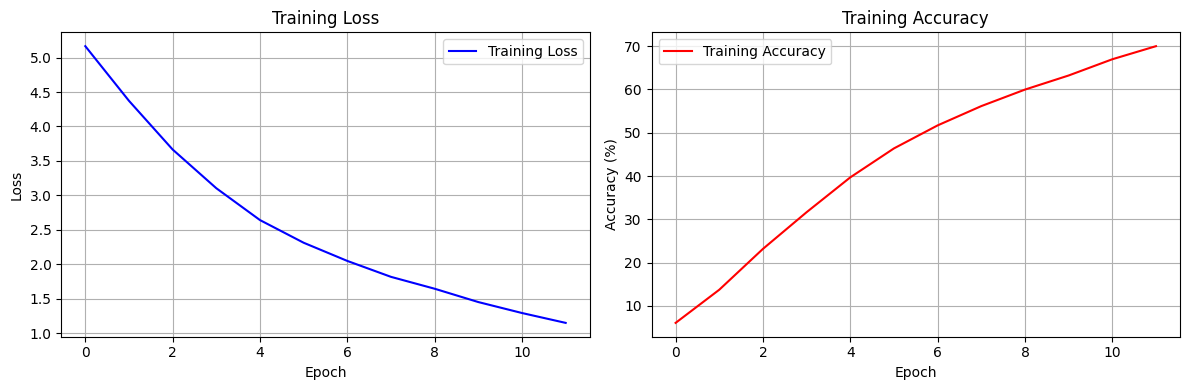


💾 STEP 7: Saving the model
Mounted at /content/drive
✅ Model saved to /content/drive/MyDrive/caltech256_resnet50.pth

🎉 TRAINING COMPLETE!
Final Test Accuracy: 54.74%


In [18]:

batch_size=32
num_epochs=12
use_google_drive=True
baselineClassifier = train_caltech256_resnet50(batch_size,num_epochs,use_google_drive)


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, random_split
from tqdm import tqdm
import matplotlib.pyplot as plt
import os
import urllib.request
import tarfile
import math
import numpy as np
from collections import defaultdict

class SphericalLSHLoss(nn.Module):
    """
    Memory-efficient Spherical Locality-Sensitive Hashing Loss.
    Encourages similar embeddings for same class, different embeddings for different classes.
    """
    def __init__(self, embedding_dim, num_hash_functions=8, margin=0.5, temperature=0.1):
        super(SphericalLSHLoss, self).__init__()
        self.embedding_dim = embedding_dim
        self.num_hash_functions = num_hash_functions
        self.margin = margin
        self.temperature = temperature

        # Initialize random hyperplanes for LSH (stored on CPU to save GPU memory)
        self.register_buffer('hyperplanes',
                           torch.randn(num_hash_functions, embedding_dim))

    def compute_lsh_hash(self, embeddings):
        """
        Compute LSH hash codes for embeddings.
        Returns binary hash codes.
        """
        # Normalize embeddings to unit sphere
        embeddings_norm = F.normalize(embeddings, p=2, dim=1)

        # Compute dot products with hyperplanes
        projections = torch.mm(embeddings_norm, self.hyperplanes.t())

        # Convert to binary hash codes (1 if positive, 0 if negative)
        hash_codes = (projections > 0).float()

        return hash_codes

    def hamming_distance(self, hash1, hash2):
        """Compute Hamming distance between hash codes."""
        return torch.sum(hash1 != hash2, dim=1).float()

    def forward(self, embeddings, labels):
        """
        Compute Spherical LSH loss.

        Args:
            embeddings: Feature embeddings [batch_size, embedding_dim]
            labels: Class labels [batch_size]
        """
        batch_size = embeddings.size(0)
        if batch_size == 1:
            return torch.tensor(0.0, device=embeddings.device, requires_grad=True)

        # Compute LSH hash codes
        hash_codes = self.compute_lsh_hash(embeddings)

        # Create masks for same/different class pairs
        labels_expanded = labels.unsqueeze(1).expand(batch_size, batch_size)
        same_class_mask = (labels_expanded == labels_expanded.t()).float()
        diff_class_mask = 1.0 - same_class_mask

        # Remove diagonal (self-comparisons)
        eye_mask = torch.eye(batch_size, device=embeddings.device)
        same_class_mask = same_class_mask * (1.0 - eye_mask)
        diff_class_mask = diff_class_mask * (1.0 - eye_mask)

        # Compute pairwise Hamming distances (memory efficient)
        hash_expanded1 = hash_codes.unsqueeze(1).expand(batch_size, batch_size, self.num_hash_functions)
        hash_expanded2 = hash_codes.unsqueeze(0).expand(batch_size, batch_size, self.num_hash_functions)
        hamming_distances = torch.sum(hash_expanded1 != hash_expanded2, dim=2).float()

        # Normalize distances by number of hash functions
        hamming_distances = hamming_distances / self.num_hash_functions

        # Same class loss: minimize distance between same class samples
        same_class_loss = torch.sum(hamming_distances * same_class_mask) / (torch.sum(same_class_mask) + 1e-8)

        # Different class loss: maximize distance between different class samples
        # Use margin-based loss with temperature scaling
        margin_distances = torch.clamp(self.margin - hamming_distances, min=0.0)
        diff_class_loss = torch.sum(margin_distances * diff_class_mask) / (torch.sum(diff_class_mask) + 1e-8)

        total_loss = same_class_loss + diff_class_loss

        return total_loss

class SphericalLSHClassifier:
    def __init__(self, num_classes, embedding_dim=512, batch_size=16, lr=0.001,
                 lsh_weight=0.1, num_hash_functions=8, device=None):
        """
        Memory-efficient ResNet50 classifier with Spherical LSH loss.

        Args:
            num_classes (int): Number of classes in dataset
            embedding_dim (int): Dimension of feature embeddings for LSH
            batch_size (int): Batch size (kept small for memory efficiency)
            lr (float): Learning rate
            lsh_weight (float): Weight for LSH loss component
            num_hash_functions (int): Number of hash functions for LSH
            device: PyTorch device
        """
        self.num_classes = num_classes
        self.embedding_dim = embedding_dim
        self.batch_size = batch_size
        self.lr = lr
        self.lsh_weight = lsh_weight
        self.device = device or torch.device("cuda" if torch.cuda.is_available() else "cpu")

        # Initialize model with feature extractor
        self.model = self._create_model()
        self.model.to(self.device)

        # Loss functions
        self.classification_loss = nn.CrossEntropyLoss()
        self.lsh_loss = SphericalLSHLoss(
            embedding_dim=embedding_dim,
            num_hash_functions=num_hash_functions,
            margin=0.5,
            temperature=0.1
        ).to(self.device)

        # Optimizer with weight decay for regularization
        self.optimizer = optim.AdamW(
            self.model.parameters(),
            lr=self.lr,
            weight_decay=1e-4
        )

        # Learning rate scheduler
        self.scheduler = optim.lr_scheduler.ReduceLROnPlateau(
            self.optimizer,
            mode='min',
            factor=0.5,
            patience=3,
            verbose=True
        )

        # Training history
        self.train_losses = []
        self.train_accuracies = []
        self.lsh_losses = []
        self.classification_losses = []

        print(f"Using device: {self.device}")
        print(f"Model: ResNet50 with Spherical LSH")
        print(f"Classes: {num_classes}, Embedding dim: {embedding_dim}")
        print(f"LSH hash functions: {num_hash_functions}, LSH weight: {lsh_weight}")
        print(f"Batch size: {batch_size} (optimized for memory efficiency)")

    def _create_model(self):
        """Create ResNet50 with additional embedding layer for LSH."""
        # Load pretrained ResNet50
        model = models.resnet50(pretrained=True)

        # Replace the classifier with a dual-head architecture
        num_features = model.fc.in_features

        # Remove the original classifier
        model.fc = nn.Identity()

        # Add custom classifier head
        model.classifier = nn.Linear(num_features, self.num_classes)

        # Add embedding head for LSH
        model.embedding = nn.Sequential(
            nn.Linear(num_features, self.embedding_dim),
            nn.BatchNorm1d(self.embedding_dim),
            nn.ReLU(inplace=True),
            nn.Dropout(0.3)
        )

        return model

    def forward_with_embeddings(self, x):
        """Forward pass returning both classification logits and embeddings."""
        # Extract features using ResNet backbone
        features = self.model.avgpool(self.model.layer4(
            self.model.layer3(self.model.layer2(self.model.layer1(
                self.model.maxpool(self.model.relu(self.model.bn1(self.model.conv1(x))))
            )))
        ))
        features = torch.flatten(features, 1)

        # Get classification logits and embeddings
        logits = self.model.classifier(features)
        embeddings = self.model.embedding(features)

        return logits, embeddings

    def prepare_data_loaders(self, dataset_path, train_ratio=0.8, image_size=224):
        """Create memory-efficient data loaders."""
        # Data transforms with aggressive augmentation
        train_transform = transforms.Compose([
            transforms.Resize((image_size + 32, image_size + 32)),
            transforms.RandomCrop((image_size, image_size)),
            transforms.RandomHorizontalFlip(0.5),
            transforms.RandomRotation(15),
            transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])

        test_transform = transforms.Compose([
            transforms.Resize((image_size, image_size)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])

        # Load dataset
        full_dataset = datasets.ImageFolder(root=dataset_path, transform=train_transform)

        # Split dataset
        train_size = int(train_ratio * len(full_dataset))
        test_size = len(full_dataset) - train_size
        train_dataset, test_dataset = random_split(full_dataset, [train_size, test_size])

        # Apply test transforms to test set
        test_dataset.dataset = datasets.ImageFolder(root=dataset_path, transform=test_transform)

        # Create memory-efficient data loaders
        self.train_loader = DataLoader(
            train_dataset,
            batch_size=self.batch_size,
            shuffle=True,
            num_workers=2,
            pin_memory=True if self.device.type == 'cuda' else False,
            drop_last=True  # Ensure consistent batch sizes for LSH loss
        )

        self.test_loader = DataLoader(
            test_dataset,
            batch_size=self.batch_size,
            shuffle=False,
            num_workers=2,
            pin_memory=True if self.device.type == 'cuda' else False
        )

        self.class_names = full_dataset.classes

        print(f"Dataset loaded: {len(full_dataset)} images")
        print(f"Train: {train_size}, Test: {test_size}")
        print(f"Classes: {len(self.class_names)} categories")

        return self.train_loader, self.test_loader

    def train(self, num_epochs=10, print_every=1):
        """Memory-efficient training with mixed loss."""
        self.model.train()

        for epoch in range(num_epochs):
            running_loss = 0.0
            running_cls_loss = 0.0
            running_lsh_loss = 0.0
            correct_predictions = 0
            total_predictions = 0

            progress_bar = tqdm(self.train_loader, desc=f"Epoch {epoch + 1}/{num_epochs}")

            for batch_idx, (images, labels) in enumerate(progress_bar):
                images = images.to(self.device, non_blocking=True)
                labels = labels.to(self.device, non_blocking=True)

                # Forward pass
                logits, embeddings = self.forward_with_embeddings(images)

                # Classification loss
                cls_loss = self.classification_loss(logits, labels)

                # LSH loss
                lsh_loss = self.lsh_loss(embeddings, labels)

                # Combined loss
                total_loss = cls_loss + self.lsh_weight * lsh_loss

                # Backward pass
                self.optimizer.zero_grad()
                total_loss.backward()

                # Gradient clipping for stability
                torch.nn.utils.clip_grad_norm_(self.model.parameters(), max_norm=1.0)

                self.optimizer.step()

                # Statistics
                running_loss += total_loss.item()
                running_cls_loss += cls_loss.item()
                running_lsh_loss += lsh_loss.item()

                _, predicted = torch.max(logits, 1)
                total_predictions += labels.size(0)
                correct_predictions += (predicted == labels).sum().item()

                # Update progress bar
                progress_bar.set_postfix({
                    "Total": f"{total_loss.item():.4f}",
                    "Cls": f"{cls_loss.item():.4f}",
                    "LSH": f"{lsh_loss.item():.4f}",
                    "Acc": f"{100 * correct_predictions / total_predictions:.2f}%"
                })

                # Memory cleanup every 50 batches
                if batch_idx % 50 == 0:
                    torch.cuda.empty_cache() if self.device.type == 'cuda' else None

            # Calculate epoch metrics
            epoch_loss = running_loss / len(self.train_loader)
            epoch_cls_loss = running_cls_loss / len(self.train_loader)
            epoch_lsh_loss = running_lsh_loss / len(self.train_loader)
            epoch_acc = 100 * correct_predictions / total_predictions

            # Update learning rate
            self.scheduler.step(epoch_loss)

            # Store history
            self.train_losses.append(epoch_loss)
            self.train_accuracies.append(epoch_acc)
            self.classification_losses.append(epoch_cls_loss)
            self.lsh_losses.append(epoch_lsh_loss)

            if (epoch + 1) % print_every == 0:
                print(f"Epoch {epoch + 1}/{num_epochs}")
                print(f"  Total Loss: {epoch_loss:.4f}")
                print(f"  Classification Loss: {epoch_cls_loss:.4f}")
                print(f"  LSH Loss: {epoch_lsh_loss:.4f}")
                print(f"  Accuracy: {epoch_acc:.2f}%")
                print(f"  Learning Rate: {self.optimizer.param_groups[0]['lr']:.6f}")

    def evaluate(self):
        """Evaluate model on test set."""
        self.model.eval()
        correct = 0
        total = 0

        with torch.no_grad():
            for images, labels in tqdm(self.test_loader, desc="Evaluating"):
                images = images.to(self.device, non_blocking=True)
                labels = labels.to(self.device, non_blocking=True)

                logits, _ = self.forward_with_embeddings(images)
                _, predicted = torch.max(logits, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        accuracy = 100 * correct / total
        print(f"Test Accuracy: {accuracy:.2f}%")
        return accuracy

    def plot_training_history(self):
        """Plot comprehensive training curves."""
        if not self.train_losses:
            print("No training history to plot.")
            return

        fig, axes = plt.subplots(2, 2, figsize=(15, 10))

        # Total loss
        axes[0, 0].plot(self.train_losses, 'b-', label='Total Loss')
        axes[0, 0].set_title('Total Training Loss')
        axes[0, 0].set_xlabel('Epoch')
        axes[0, 0].set_ylabel('Loss')
        axes[0, 0].legend()
        axes[0, 0].grid(True)

        # Classification vs LSH loss
        axes[0, 1].plot(self.classification_losses, 'r-', label='Classification Loss')
        axes[0, 1].plot(self.lsh_losses, 'g-', label='LSH Loss')
        axes[0, 1].set_title('Loss Components')
        axes[0, 1].set_xlabel('Epoch')
        axes[0, 1].set_ylabel('Loss')
        axes[0, 1].legend()
        axes[0, 1].grid(True)

        # Training accuracy
        axes[1, 0].plot(self.train_accuracies, 'purple', label='Training Accuracy')
        axes[1, 0].set_title('Training Accuracy')
        axes[1, 0].set_xlabel('Epoch')
        axes[1, 0].set_ylabel('Accuracy (%)')
        axes[1, 0].legend()
        axes[1, 0].grid(True)

        # LSH loss detail
        axes[1, 1].plot(self.lsh_losses, 'orange', label='LSH Loss')
        axes[1, 1].set_title('Spherical LSH Loss')
        axes[1, 1].set_xlabel('Epoch')
        axes[1, 1].set_ylabel('LSH Loss')
        axes[1, 1].legend()
        axes[1, 1].grid(True)

        plt.tight_layout()
        plt.show()

    def save_model(self, path):
        """Save the trained model."""
        torch.save({
            'model_state_dict': self.model.state_dict(),
            'optimizer_state_dict': self.optimizer.state_dict(),
            'scheduler_state_dict': self.scheduler.state_dict(),
            'num_classes': self.num_classes,
            'embedding_dim': self.embedding_dim,
            'lsh_weight': self.lsh_weight,
            'class_names': self.class_names if hasattr(self, 'class_names') else None,
            'hyperplanes': self.lsh_loss.hyperplanes
        }, path)
        print(f"Model saved to {path}")

    def get_gpu_memory_usage(self):
        """Get current GPU memory usage."""
        if torch.cuda.is_available():
            return torch.cuda.memory_allocated() / 1024**3  # GB
        return 0


def download_and_prepare_caltech256(download_root='./data'):
    """Download and extract Caltech-256 dataset."""
    dataset_url = "https://data.caltech.edu/records/nyy15-4j048/files/256_ObjectCategories.tar?download=1"
    dataset_filename = "256_ObjectCategories.tar"
    dataset_path = os.path.join(download_root, dataset_filename)
    extracted_path = os.path.join(download_root, "256_ObjectCategories")

    os.makedirs(download_root, exist_ok=True)

    if not os.path.exists(dataset_path):
        print(f"Downloading Caltech-256 dataset...")
        try:
            urllib.request.urlretrieve(dataset_url, dataset_path)
            print("✅ Download completed!")
        except Exception as e:
            print(f"❌ Download failed: {e}")
            return None

    if not os.path.exists(extracted_path):
        print("Extracting dataset...")
        try:
            with tarfile.open(dataset_path, "r:") as tar:
                tar.extractall(path=download_root)
            print("✅ Extraction completed!")
        except Exception as e:
            print(f"❌ Extraction failed: {e}")
            return None

    if os.path.exists(extracted_path):
        categories = [d for d in os.listdir(extracted_path)
                     if os.path.isdir(os.path.join(extracted_path, d))]
        print(f"✅ Dataset ready! Found {len(categories)} categories.")
        return extracted_path

    return None


def train_caltech256_spherical_lsh():
    """
    Train ResNet50 with Spherical LSH loss on Caltech-256.
    Optimized for modest GPU memory.
    """
    print("=" * 70)
    print("CALTECH-256 RESNET50 + SPHERICAL LSH TRAINING")
    print("=" * 70)

    # Download dataset
    dataset_path = download_and_prepare_caltech256()
    if dataset_path is None:
        return None

    # Create classifier with memory-efficient settings
    classifier = SphericalLSHClassifier(
        num_classes=257,
        embedding_dim=256,      # Reduced embedding dimension
        batch_size=8,           # Small batch size for modest GPU
        lr=0.0005,              # Lower learning rate for stability
        lsh_weight=0.05,        # LSH loss weight
        num_hash_functions=6    # Fewer hash functions to save memory
    )

    print(f"🔥 Initial GPU memory: {classifier.get_gpu_memory_usage():.2f} GB")

    # Prepare data loaders
    classifier.prepare_data_loaders(dataset_path, train_ratio=0.8)

    # Train model
    classifier.train(num_epochs=15)

    print(f"🔥 Peak GPU memory: {classifier.get_gpu_memory_usage():.2f} GB")

    # Evaluate
    test_accuracy = classifier.evaluate()

    # Plot results
    classifier.plot_training_history()

    # Save model
    classifier.save_model('caltech256_spherical_lsh_resnet50.pth')

    print(f"\n🎉 Training completed! Final accuracy: {test_accuracy:.2f}%")

    return classifier


# Memory-optimized version for very modest GPUs
def train_caltech256_memory_optimized():
    """Ultra memory-efficient version for very modest GPUs."""

    dataset_path = download_and_prepare_caltech256()
    if dataset_path is None:
        return None

    classifier = SphericalLSHClassifier(
        num_classes=257,
        embedding_dim=128,      # Even smaller embedding
        batch_size=4,           # Very small batch size
        lr=0.0003,
        lsh_weight=0.03,
        num_hash_functions=4    # Minimal hash functions
    )

    classifier.prepare_data_loaders(dataset_path, train_ratio=0.8, image_size=192)  # Smaller images
    classifier.train(num_epochs=10)
    accuracy = classifier.evaluate()
    classifier.plot_training_history()

    return classifier

🎯 Custom Training Configuration:
   Epochs: 10
   Batch Size: 32
   LSH Weight: 0.15
   Embedding Dim: 128
   Hash Functions: 6
✅ Dataset ready! Found 257 categories.
Using device: cuda
Model: ResNet50 with Spherical LSH
Classes: 257, Embedding dim: 128
LSH hash functions: 6, LSH weight: 0.15
Batch size: 32 (optimized for memory efficiency)
Dataset loaded: 30607 images
Train: 24485, Test: 6122
Classes: 257 categories


Epoch 1/10: 100%|██████████| 765/765 [04:49<00:00,  2.64it/s, Total=5.3232, Cls=5.1848, LSH=0.9226, Acc=5.33%]


Epoch 1/10
  Total Loss: 5.2933
  Classification Loss: 5.2167
  LSH Loss: 0.5106
  Accuracy: 5.33%
  Learning Rate: 0.001000


Epoch 2/10: 100%|██████████| 765/765 [04:49<00:00,  2.64it/s, Total=4.7413, Cls=4.6487, LSH=0.6172, Acc=11.08%]


Epoch 2/10
  Total Loss: 4.6829
  Classification Loss: 4.6083
  LSH Loss: 0.4977
  Accuracy: 11.08%
  Learning Rate: 0.001000


Epoch 3/10: 100%|██████████| 765/765 [04:50<00:00,  2.63it/s, Total=3.9230, Cls=3.8350, LSH=0.5870, Acc=16.27%]


Epoch 3/10
  Total Loss: 4.2336
  Classification Loss: 4.1589
  LSH Loss: 0.4980
  Accuracy: 16.27%
  Learning Rate: 0.001000


Epoch 4/10: 100%|██████████| 765/765 [04:50<00:00,  2.64it/s, Total=3.5664, Cls=3.5535, LSH=0.0857, Acc=22.00%]


Epoch 4/10
  Total Loss: 3.8167
  Classification Loss: 3.7423
  LSH Loss: 0.4960
  Accuracy: 22.00%
  Learning Rate: 0.001000


Epoch 5/10: 100%|██████████| 765/765 [04:50<00:00,  2.63it/s, Total=2.9273, Cls=2.9138, LSH=0.0901, Acc=28.27%]


Epoch 5/10
  Total Loss: 3.4007
  Classification Loss: 3.3302
  LSH Loss: 0.4702
  Accuracy: 28.27%
  Learning Rate: 0.001000


Epoch 6/10: 100%|██████████| 765/765 [04:47<00:00,  2.66it/s, Total=3.2125, Cls=3.1470, LSH=0.4364, Acc=34.20%]


Epoch 6/10
  Total Loss: 3.0516
  Classification Loss: 2.9777
  LSH Loss: 0.4931
  Accuracy: 34.20%
  Learning Rate: 0.001000


Epoch 7/10: 100%|██████████| 765/765 [04:47<00:00,  2.66it/s, Total=2.2233, Cls=2.1719, LSH=0.3431, Acc=39.70%]


Epoch 7/10
  Total Loss: 2.7526
  Classification Loss: 2.6793
  LSH Loss: 0.4888
  Accuracy: 39.70%
  Learning Rate: 0.001000


Epoch 8/10: 100%|██████████| 765/765 [04:49<00:00,  2.64it/s, Total=2.4911, Cls=2.4038, LSH=0.5822, Acc=44.15%]


Epoch 8/10
  Total Loss: 2.5125
  Classification Loss: 2.4402
  LSH Loss: 0.4817
  Accuracy: 44.15%
  Learning Rate: 0.001000


Epoch 9/10: 100%|██████████| 765/765 [04:49<00:00,  2.64it/s, Total=2.8764, Cls=2.7648, LSH=0.7441, Acc=48.18%]


Epoch 9/10
  Total Loss: 2.2981
  Classification Loss: 2.2251
  LSH Loss: 0.4868
  Accuracy: 48.18%
  Learning Rate: 0.001000


Epoch 10/10: 100%|██████████| 765/765 [04:48<00:00,  2.65it/s, Total=2.2650, Cls=2.1944, LSH=0.4709, Acc=51.50%]


Epoch 10/10
  Total Loss: 2.1303
  Classification Loss: 2.0569
  LSH Loss: 0.4896
  Accuracy: 51.50%
  Learning Rate: 0.001000


Evaluating: 100%|██████████| 192/192 [00:28<00:00,  6.82it/s]


Test Accuracy: 48.14%


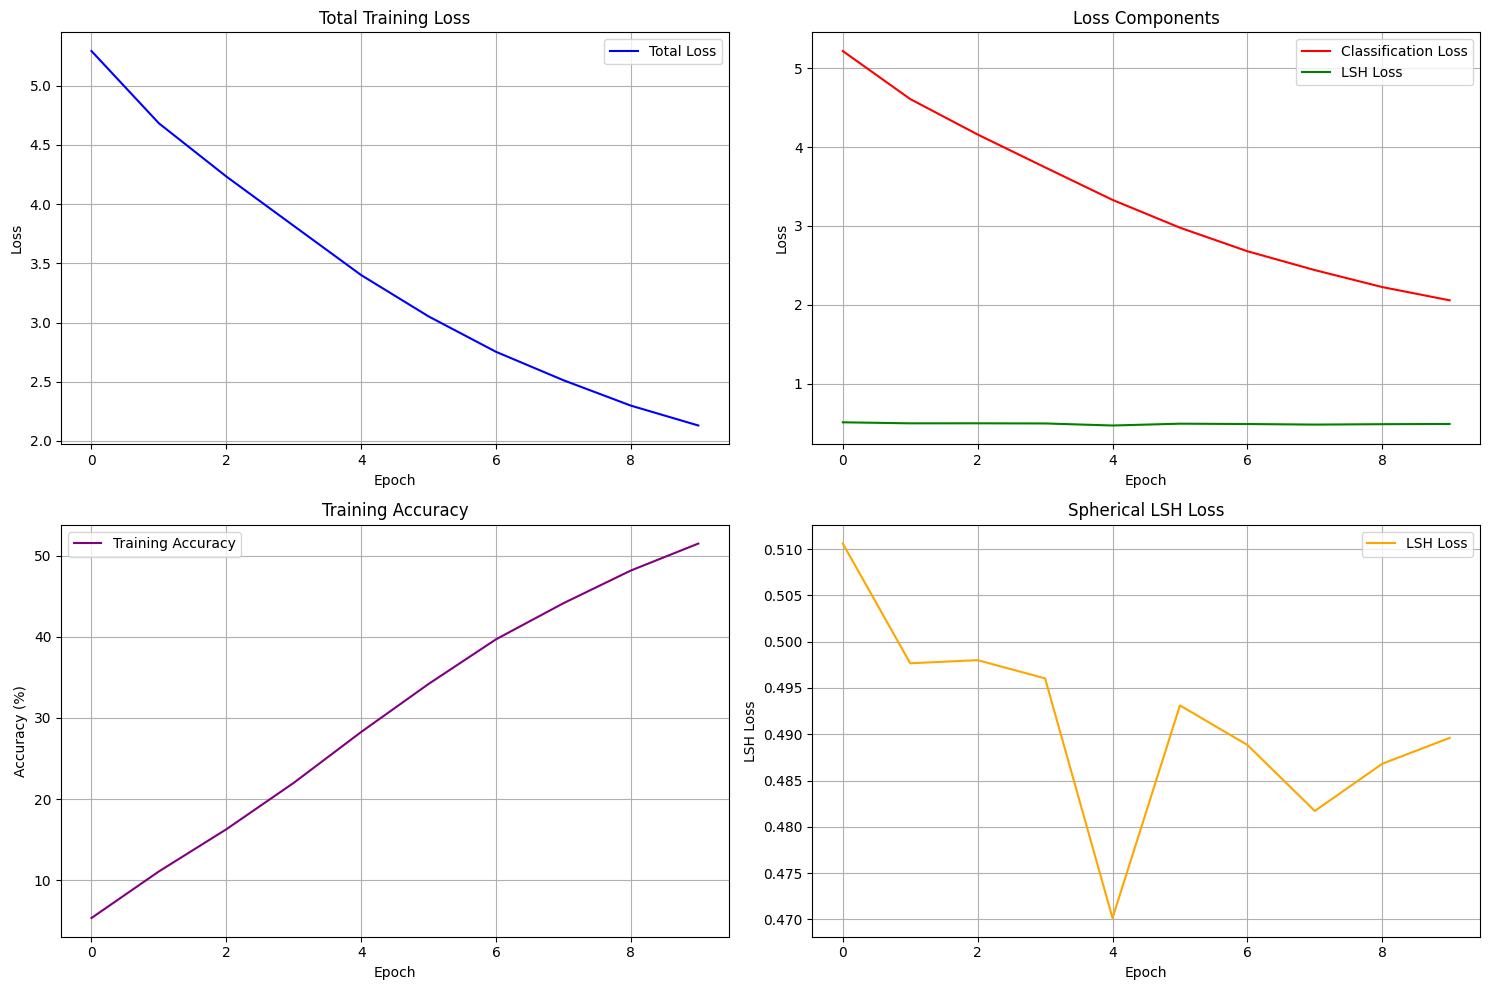


📋 QUICK REFERENCE:
• quick_demo() - Fast 3-epoch demo
• full_training_example() - Complete training
• ultra_memory_efficient() - For <4GB GPUs
• custom_training_example() - Your parameters


In [ ]:
# ====================================================================
# COMPLETE EXAMPLE: SPHERICAL LSH RESNET50 ON CALTECH-256
# ====================================================================

# First, install required packages if needed (run in Google Colab)
# !pip install torch torchvision tqdm matplotlib

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, random_split
from tqdm import tqdm
import matplotlib.pyplot as plt
import os
import urllib.request
import tarfile
import math
import numpy as np
from collections import defaultdict

# ====================================================================
# STEP 1: COPY THE SPHERICAL LSH CLASSIFIER CODE
# ====================================================================
# (Copy the SphericalLSHLoss and SphericalLSHClassifier classes from the previous artifact)

# ====================================================================
# STEP 2: SIMPLE EXAMPLE - JUST RUN THIS!
# ====================================================================

def quick_demo():
    """
    Quick demonstration - just run this function!
    Perfect for testing on modest GPUs.
    """
    print("🚀 Starting Spherical LSH Classifier Demo")
    print("=" * 50)

    # Check GPU availability
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")

    if torch.cuda.is_available():
        print(f"GPU: {torch.cuda.get_device_name(0)}")
        print(f"GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.1f} GB")

    # Download and prepare Caltech-256
    print("\n📥 Downloading Caltech-256 dataset...")
    dataset_path = download_and_prepare_caltech256()

    if dataset_path is None:
        print("❌ Dataset preparation failed!")
        return None

    # Create classifier with conservative settings for modest GPU
    print("\n🧠 Creating Spherical LSH Classifier...")
    classifier = SphericalLSHClassifier(
        num_classes=257,
        embedding_dim=128,      # Small embedding for memory efficiency
        batch_size=8,           # Small batch size
        lr=0.001,
        lsh_weight=0.1,         # Weight for LSH loss
        num_hash_functions=6    # Moderate number of hash functions
    )

    # Prepare data loaders
    print("\n📊 Preparing data loaders...")
    classifier.prepare_data_loaders(
        dataset_path=dataset_path,
        train_ratio=0.8,
        image_size=224
    )

    print(f"\n🔥 Initial GPU memory usage: {classifier.get_gpu_memory_usage():.2f} GB")

    # Train the model (short demo)
    print("\n🏋️ Starting training...")
    classifier.train(num_epochs=3)  # Short demo - increase for better results

    print(f"🔥 Peak GPU memory usage: {classifier.get_gpu_memory_usage():.2f} GB")

    # Evaluate
    print("\n📈 Evaluating model...")
    accuracy = classifier.evaluate()

    # Plot training history
    print("\n📊 Plotting results...")
    classifier.plot_training_history()

    # Save model
    classifier.save_model('demo_spherical_lsh_model.pth')

    print(f"\n🎉 Demo completed! Final accuracy: {accuracy:.2f}%")
    return classifier

# ====================================================================
# STEP 3: FULL TRAINING EXAMPLE
# ====================================================================

def full_training_example():
    """
    Complete training example with optimal settings.
    Use this for actual training runs.
    """
    print("🔥 Full Training: Spherical LSH ResNet50 on Caltech-256")
    print("=" * 60)

    # Check available GPU memory and adjust settings accordingly
    if torch.cuda.is_available():
        gpu_memory_gb = torch.cuda.get_device_properties(0).total_memory / 1e9
        print(f"Detected GPU memory: {gpu_memory_gb:.1f} GB")

        # Adjust settings based on GPU memory
        if gpu_memory_gb >= 8:
            batch_size = 16
            embedding_dim = 256
            num_hash_functions = 8
            print("🚀 Using high-memory settings")
        elif gpu_memory_gb >= 6:
            batch_size = 12
            embedding_dim = 192
            num_hash_functions = 6
            print("⚡ Using medium-memory settings")
        else:
            batch_size = 8
            embedding_dim = 128
            num_hash_functions = 4
            print("💾 Using low-memory settings")
    else:
        batch_size = 4
        embedding_dim = 128
        num_hash_functions = 4
        print("💻 Using CPU settings")

    # Download dataset
    dataset_path = download_and_prepare_caltech256()
    if dataset_path is None:
        return None

    # Create classifier
    classifier = SphericalLSHClassifier(
        num_classes=257,
        embedding_dim=embedding_dim,
        batch_size=batch_size,
        lr=0.0005,              # Conservative learning rate
        lsh_weight=0.05,        # LSH loss weight
        num_hash_functions=num_hash_functions
    )

    # Prepare data
    classifier.prepare_data_loaders(dataset_path, train_ratio=0.8)

    # Train model
    classifier.train(num_epochs=15)

    # Evaluate and plot
    accuracy = classifier.evaluate()
    classifier.plot_training_history()

    # Save model
    classifier.save_model('caltech256_spherical_lsh_final.pth')

    print(f"🏆 Training completed! Final accuracy: {accuracy:.2f}%")
    return classifier

# ====================================================================
# STEP 4: CUSTOM TRAINING WITH YOUR PARAMETERS
# ====================================================================

def custom_training_example(epochs=10, batch_size=8, lsh_weight=0.1,
                          embedding_dim=128, num_hash_functions=6):
    """
    Custom training with your specified parameters.

    Args:
        epochs: Number of training epochs
        batch_size: Batch size (keep small for memory efficiency)
        lsh_weight: Weight for LSH loss component
        embedding_dim: Dimension of LSH embeddings
        num_hash_functions: Number of LSH hash functions
    """
    print(f"🎯 Custom Training Configuration:")
    print(f"   Epochs: {epochs}")
    print(f"   Batch Size: {batch_size}")
    print(f"   LSH Weight: {lsh_weight}")
    print(f"   Embedding Dim: {embedding_dim}")
    print(f"   Hash Functions: {num_hash_functions}")
    print("=" * 50)

    # Dataset preparation
    dataset_path = download_and_prepare_caltech256()
    if dataset_path is None:
        return None

    # Create classifier with custom settings
    classifier = SphericalLSHClassifier(
        num_classes=257,
        embedding_dim=embedding_dim,
        batch_size=batch_size,
        lr=0.001,
        lsh_weight=lsh_weight,
        num_hash_functions=num_hash_functions
    )

    # Train and evaluate
    classifier.prepare_data_loaders(dataset_path)
    classifier.train(num_epochs=epochs)
    accuracy = classifier.evaluate()
    classifier.plot_training_history()

    return classifier

# ====================================================================
# STEP 5: MEMORY-EFFICIENT VERSION FOR VERY MODEST GPUS
# ====================================================================

def ultra_memory_efficient():
    """
    Ultra memory-efficient version for GPUs with <4GB VRAM.
    """
    print("💾 Ultra Memory-Efficient Mode")
    print("Optimized for GPUs with <4GB VRAM")
    print("=" * 40)

    dataset_path = download_and_prepare_caltech256()
    if dataset_path is None:
        return None

    classifier = SphericalLSHClassifier(
        num_classes=257,
        embedding_dim=64,       # Very small embedding
        batch_size=4,           # Tiny batch size
        lr=0.0008,
        lsh_weight=0.03,        # Lower LSH weight
        num_hash_functions=4    # Minimal hash functions
    )

    # Use smaller image size to save memory
    classifier.prepare_data_loaders(dataset_path, image_size=192)

    # Train with checkpointing to save memory
    classifier.train(num_epochs=8)
    accuracy = classifier.evaluate()
    classifier.plot_training_history()

    return classifier

# ====================================================================
# STEP 6: ANALYSIS AND VISUALIZATION
# ====================================================================

def analyze_lsh_performance(classifier):
    """
    Analyze the LSH performance on a trained model.
    """
    if not hasattr(classifier, 'model'):
        print("❌ No trained model found!")
        return

    print("\n🔍 Analyzing LSH Performance...")

    classifier.model.eval()
    embeddings_list = []
    labels_list = []
    hash_codes_list = []

    # Collect embeddings and hash codes from test set
    with torch.no_grad():
        for i, (images, labels) in enumerate(classifier.test_loader):
            if i >= 10:  # Analyze first 10 batches
                break

            images = images.to(classifier.device)
            logits, embeddings = classifier.forward_with_embeddings(images)

            # Compute LSH hash codes
            hash_codes = classifier.lsh_loss.compute_lsh_hash(embeddings)

            embeddings_list.append(embeddings.cpu())
            labels_list.append(labels)
            hash_codes_list.append(hash_codes.cpu())

    # Combine all embeddings
    all_embeddings = torch.cat(embeddings_list, dim=0)
    all_labels = torch.cat(labels_list, dim=0)
    all_hash_codes = torch.cat(hash_codes_list, dim=0)

    # Analyze hash code statistics
    print(f"📊 LSH Analysis Results:")
    print(f"   Total samples analyzed: {len(all_labels)}")
    print(f"   Embedding dimension: {all_embeddings.shape[1]}")
    print(f"   Hash code dimension: {all_hash_codes.shape[1]}")

    # Calculate average intra-class and inter-class distances
    unique_labels = torch.unique(all_labels)
    intra_distances = []
    inter_distances = []

    for label in unique_labels[:10]:  # Analyze first 10 classes
        mask = (all_labels == label)
        class_hash_codes = all_hash_codes[mask]

        if len(class_hash_codes) > 1:
            # Intra-class distances
            for i in range(len(class_hash_codes)):
                for j in range(i+1, len(class_hash_codes)):
                    dist = torch.sum(class_hash_codes[i] != class_hash_codes[j]).item()
                    intra_distances.append(dist)

        # Inter-class distances (sample a few)
        other_mask = (all_labels != label)
        other_hash_codes = all_hash_codes[other_mask]

        if len(other_hash_codes) > 0:
            for i in range(min(10, len(class_hash_codes))):
                for j in range(min(10, len(other_hash_codes))):
                    dist = torch.sum(class_hash_codes[i] != other_hash_codes[j]).item()
                    inter_distances.append(dist)

    if intra_distances and inter_distances:
        avg_intra = np.mean(intra_distances)
        avg_inter = np.mean(inter_distances)

        print(f"   Average intra-class distance: {avg_intra:.2f}")
        print(f"   Average inter-class distance: {avg_inter:.2f}")
        print(f"   Separation ratio: {avg_inter/avg_intra:.2f}")

        if avg_inter > avg_intra:
            print("✅ LSH is working: inter-class > intra-class distances")
        else:
            print("⚠️ LSH needs improvement: intra-class distances too high")

# ====================================================================
# MAIN EXECUTION - CHOOSE YOUR OPTION!
# ====================================================================

def main():
    """
    Main function - choose which example to run!
    """
    print("🎯 Spherical LSH ResNet50 Classifier Examples")
    print("=" * 50)
    print("Choose an option:")
    print("1. Quick Demo (3 epochs, memory-efficient)")
    print("2. Full Training (15 epochs, adaptive settings)")
    print("3. Ultra Memory-Efficient (<4GB GPU)")
    print("4. Custom Training")
    print("5. Run All Examples")

    # For Google Colab - just run option 1 by default
    print("\n🚀 Running Quick Demo (Option 1)...")
    classifier = quick_demo()

    if classifier:
        print("\n🔍 Analyzing LSH performance...")
        analyze_lsh_performance(classifier)

    return classifier

# ====================================================================
# GOOGLE COLAB QUICK START
# ====================================================================

# Just run this in Google Colab!
if __name__ == "__main__":
    # Quick start - runs automatically
    #classifier = main()

    # If you want to run other examples, uncomment below:

    # Full training example:
    # classifier = full_training_example()

    # Ultra memory-efficient:
    # classifier = ultra_memory_efficient()

    # Custom training:
    # classifier = custom_training_example(
    #     epochs=5,
    #     batch_size=6,
    #     lsh_weight=0.08,
    #     embedding_dim=96,
    #     num_hash_functions=5
    # )

# ====================================================================
# ONE-LINER EXAMPLES FOR QUICK TESTING
# ====================================================================

# Copy and paste any of these one-liners in Google Colab:

# Example 1: Quick test (recommended for first run)
# classifier = quick_demo()

# Example 2: Full training with automatic GPU detection
#classifier = full_training_example()

# Example 3: Memory-efficient for modest GPUs
# classifier = ultra_memory_efficient()

# Example 4: Custom parameters
  classifier = custom_training_example(epochs=10, batch_size=32, lsh_weight=0.15)

print("\n" + "="*60)
print("📋 QUICK REFERENCE:")
print("• quick_demo() - Fast 3-epoch demo")
print("• full_training_example() - Complete training")
print("• ultra_memory_efficient() - For <4GB GPUs")
print("• custom_training_example() - Your parameters")
print("="*60)

In [ ]:
batch_size=32
num_epochs=12
baselineClassifier = train_caltech256_resnet50(batch_size,num_epochs)

CALTECH-256 RESNET50 TRAINING EXAMPLE

📥 STEP 1: Downloading and preparing Caltech-256 dataset
Dataset already downloaded.
Dataset already extracted.
✅ Dataset ready! Found 29 categories.

🧠 STEP 2: Creating ResNet50 classifier


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Using device: cuda
Model: resnet50 with 257 classes

📊 STEP 3: Preparing data loaders
Dataset loaded: 3470 images
Train: 2776, Test: 694
Classes: 29 categories

🏋️ STEP 4: Training the model


Epoch 1/12:  64%|██████▍   | 56/87 [00:18<00:09,  3.12it/s, Loss=2.8084, Acc=30.97%]

Skipping image ./data/256_ObjectCategories/029.cannon/029_0031.jpg due to error: cannot identify image file <_io.BufferedReader name='./data/256_ObjectCategories/029.cannon/029_0031.jpg'>


Epoch 1/12:  69%|██████▉   | 60/87 [00:20<00:09,  2.94it/s, Loss=2.4536, Acc=31.35%]


RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.
